# Spherical divergence correction

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model description](#Model-description)
* [Metrics](#Metrics)
* [Manual tuning](#Manual-tuning)
* [Optimizing](#Optimizing)
* [Running time](#Running-time)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Problem description
The signal from the source fades over time but is impossible to analysing the seismogramms with low amplitude signals. In propose to increase the signal's amplitude we introduce the correction function. This function will restore the amplitude values for the entire field.

## Dataset
We are using the dataset with spherical divergence problem. This dataset has detailed description [here](../../datasets/spherical_divergence_correction.ipynb). There are many examples of corrected seismograms contains in this dataset. In purpoce to show the quality of our model we will use only raw data and corrected data with parameters v=2 and t=1.

Index field records:

In [1]:
def calc_derivative_diff(ampl_diff, window=51):
    result = measure_gain_amplitude(ampl_diff, window)
    return np.median(np.abs(np.gradient(result)))

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../..')

from seismicpro.batchflow import Dataset
from seismicpro.src import (SeismicBatch, FieldIndex, seismic_plot,
                            gain_plot, calculate_sdc_quality,
                            measure_gain_amplitude)

path_raw = '/notebooks/anton/sphere_difference/2_TAR_raw.sgy'
path_corr = '/notebooks/anton/sphere_difference/2_TAR_v2_t1.sgy'

field_index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw).
               merge(FieldIndex(name='corrected', path=path_corr)))
field_index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,corrected,corrected
FieldRecord,,,,,,
3237,3075,1,1,/notebooks/anton/sphere_difference/2_TAR_raw.sgy,1,/notebooks/anton/sphere_difference/2_TAR_v2_t1...
3237,3030,2,2,/notebooks/anton/sphere_difference/2_TAR_raw.sgy,2,/notebooks/anton/sphere_difference/2_TAR_v2_t1...
3237,2984,3,3,/notebooks/anton/sphere_difference/2_TAR_raw.sgy,3,/notebooks/anton/sphere_difference/2_TAR_v2_t1...
3237,2940,4,4,/notebooks/anton/sphere_difference/2_TAR_raw.sgy,4,/notebooks/anton/sphere_difference/2_TAR_v2_t1...
3237,2895,5,5,/notebooks/anton/sphere_difference/2_TAR_raw.sgy,5,/notebooks/anton/sphere_difference/2_TAR_v2_t1...



## Model description
The process when the amplitude of the signal on the seigmograms decreases with time named _spherical divergence_. To compensate this process the correction function - $g(t)$ is introduced and is determined by equation:
$$ g(t) = \frac{V_{rms}^{v_{pow}}(t) * t^{t_{pow}}}{V_0} \ where, $$
* $V_{rms}(t)$ - root mean square speed.
* t - time.
* $V_0$ - speed at time 0.
Here is $V_{pow}$ and $t_{pow}$ hyperparameters.

Then new amplitude value calculated as:
$$A_{new}(t) = A(t) * g(t)$$

We'll use following predefined speed.

In [3]:
speed = np.array([1524]*700 + [1924.5]*300 + [2184.0]*400 +  [2339.6]*400 + 
                 [2676]*150 + [2889.5]*2250 + [3566]*2800 + [4785.3]*1000)
time = range(0, 2000)

There are three oppunities to correct sperical divergence:
* Run spherical divergence correction with own values to hyperparameters.
* Find this hyperparameters with a built-in optimizer and use this parameters for all batch.
* Find hyperparameters for each field simultaneously.

consider each of them separately.

## Metrics

Before we start to talk about spherical divergence correction, let's determine the metrics that will be used to quality measure:
1. Gain plot.
    
    Gain's graph plots the ratio of the maximum mean value of the amplitude to the mean value of the smoothed amplitude at the moment t.
2. L1.
3. Derivative metric.

    This metric measures meduan of the difference between the first-order derivative module of two adjacent points.

## Manual tuning

For manual tuning is used ```correct_spherical_divergence``` action. To use own ```v_pow``` and ```t_pow``` values, argument ```find_params``` munst be _False_. Then you should add your own ```v_pow``` and ```t_pow``` values as an arguments.

In [4]:
%%time
batch = (Dataset(field_index, SeismicBatch).next_batch(1)
         .load(fmt='segy', components=('raw', 'corrected'), tslice=slice(3000))
         .sort_traces(src=('raw', 'corrected'), dst=('raw', 'corrected'), sort_by='offset')
         .correct_spherical_divergence(src='raw', dst='corr', time=time,
                                       speed=speed, find_params=False, v_pow=2, t_pow=1)
)

CPU times: user 440 ms, sys: 80 ms, total: 520 ms
Wall time: 520 ms


It will be useful to look at the difference between the original seismogram and the corrected one.

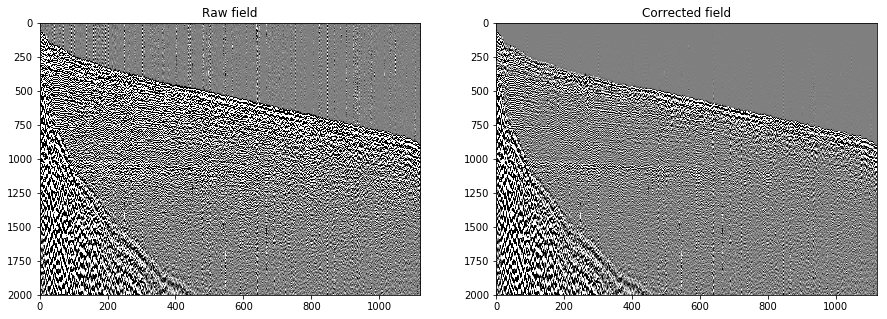

In [5]:
cv = 0.1
seismic_plot([batch.raw[0], batch.corr[0]], vmin=-cv, vmax=cv,
             cmap='gray', figsize=(15, 5), names=['Raw field', 'Corrected field'])

More clear this difference shown on gain plot. The following plot shows the ratio of the amplitude value at time t to the maximum amplitude. Our goal is to straighten this line up.

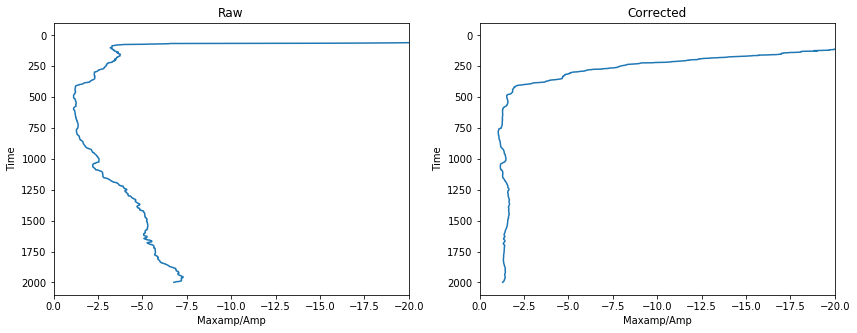

In [6]:
gain_plot([batch.raw[0], batch.corr[0]], 51, names=['Raw', 'Corrected'],
          figsize=(14, 5), xlim=(0, -20))

It's clear that the difference has narrowed since the correction was made. What about difference between corrected line and target?

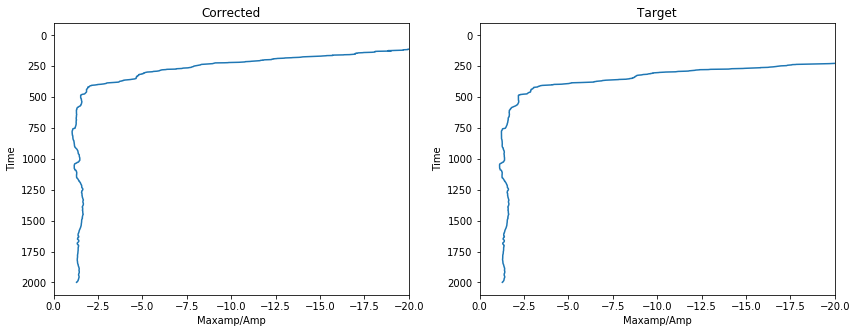

In [7]:
gain_plot([batch.corr[0], batch.corrected[0]], 51, names=['Corrected', 'Target'],
          figsize=(14, 5), xlim=(0, -20))

They look very similar. Let's calcualte the difference between this graphs and calculate the metric.

In [8]:
manual_corr = np.concatenate(batch.corr)
target_corr = np.concatenate(batch.corrected)
raw_corr = np.concatenate(batch.raw)

print('L1 measure: {:.3}'.format(np.mean(np.abs(manual_corr - target_corr))))
print('DM for raw field: {:.3}'.format(calc_derivative_diff(raw_corr)))
print('DM for manual corr: {:.3}'.format(calc_derivative_diff(manual_corr)))
print('DM for target corr: {:.3}'.format(calc_derivative_diff(target_corr)))

L1 measure: 0.00621
DM for raw field: 0.00398
DM for manual corr: 0.00192
DM for target corr: 0.0021


One can notice that the L1 between our implementation is very low. And for both of them the DM so same little. So we can conclude that our method works well.

#### Optimizing
In order to apply ```correct_spherical_divergence``` action to the whole batch, determine arguments for minimizer and add ```use_for_all=True```. Then the optimal parameters will be found for the first field and used for the rest fields. Otherwise an optimal parameters will be found for each element of batch.

In [9]:
%%time
batch_len = 1
batch = (Dataset(field_index, SeismicBatch).next_batch(batch_len)
         .load(fmt='segy', components=('raw', 'corrected'), tslice=slice(3000))
         .sort_traces(src=('raw', 'corrected'), dst=('raw', 'corrected'), sort_by='offset')
         .add_components('comp', init=np.array([None] * batch_len))
         .correct_spherical_divergence(src='raw', dst='corr', fun=calculate_sdc_quality,
                                       started_point=(2, 1), time=time, speed=speed,
                                       method='Powell', use_for_all=True, params_comp='comp')
)

CPU times: user 47.7 s, sys: 3.41 s, total: 51.1 s
Wall time: 51.1 s


In [10]:
print('Optimal parameters for v_pow is {:.3}, for t_pow is {:.3} '.format(*batch.comp))

Optimal parameters for v_pow is 2.66, for t_pow is 0.999 


Sesimograms before and after correction.

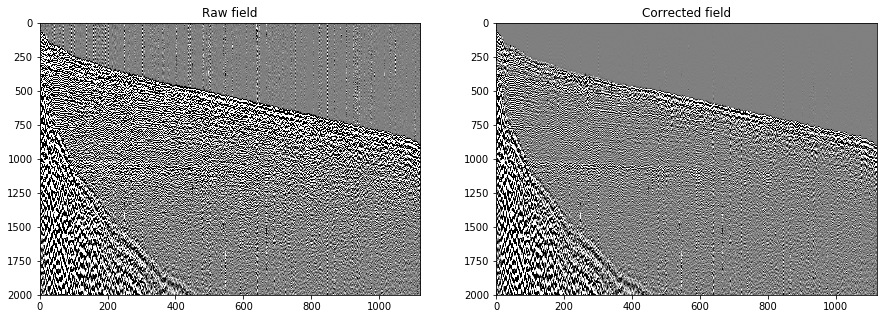

In [11]:
seismic_plot([batch.raw[0], batch.corr[0]], vmin=-cv, vmax=cv,
              cmap='gray', figsize=(15, 5), names=['Raw field', 'Corrected field'])

Graph of the amplitude difference between raw and corrected data with optimal parameters.

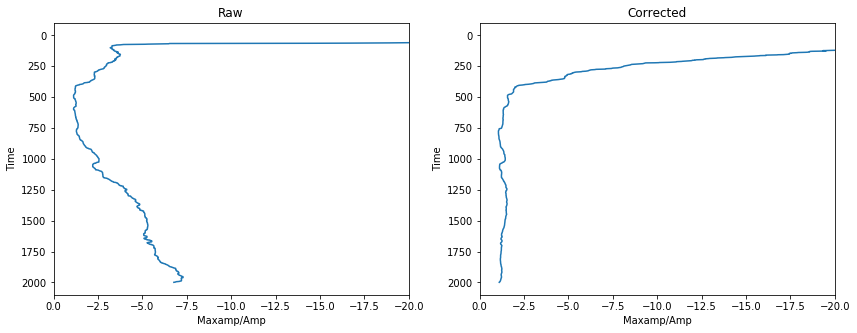

In [12]:
gain_plot([batch.raw[0], batch.corr[0]], 51, names=['Raw', 'Corrected'],
          figsize=(14, 5), xlim=(0, -20))

And calculate the quality. Does not make sence to measure L1 distance because of the different parameters, so we'll measue only DM metric.

In [13]:
manual_corr = np.concatenate(batch.corr)
raw_corr = np.concatenate(batch.raw)
print('DM for raw field: {:.3}'.format(calc_derivative_diff(raw_corr)))
print('DM for corrected field with'\
      ' optimal parameters: {:.3}'.format(calc_derivative_diff(manual_corr)))

DM for raw field: 0.00398
DM for corrected field with optimal parameters: 0.0017


We can see that the value of the metric has decreased by more than 2 times with optimal parameters.

## Running time

For Intel i7 we obtain:
* for given parameters with batch size 1 is 520 ms
* finding an optimal parameters with batch size 1 is 1 min on average.

## Criticism
Function for optimizing may not fully reflect the desired behavior of the gain plot. The function is very slow to find the optimum parameters.

## Conclusion
This notebooks shows that the correction's methods shows a good quality sometimes even better then the real data. Also we introduce the function that could be used to optimize the parameters for correction of spherical divergence.

## Suggestions for improvements
Find another function to optimize. Increase the speed of finding the optimal parameters.